# K-Means alogorithm

- My own implementation

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from data.data import load_data

In [48]:
df = load_data()
df.head()

,population_density,avg_income
0,2775,3850
1,3861,3700
2,2562,4310
3,3192,3970
4,3496,4320


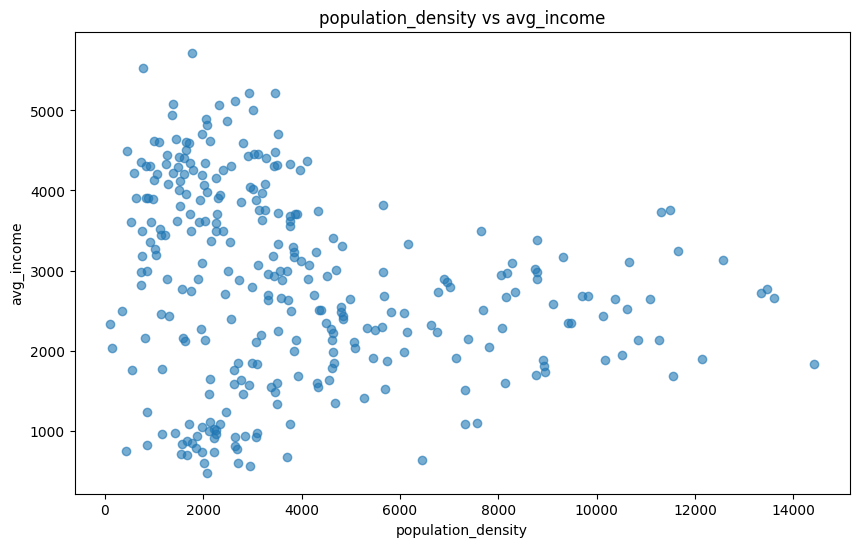

In [49]:
# visualize the data on a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], alpha=0.6)
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title(f'{df.columns[0]} vs {df.columns[1]}')
plt.show()

In [50]:
# Scale the features to be between 0 and 1
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[df.columns] = scaler.fit_transform(df)
df_scaled.describe()

,population_density,avg_income
count,300.000000,300.000000
mean,0.268363,0.447939
std,0.208178,0.229230
min,0.000000,0.000000
25%,0.120751,0.272424
50%,0.208243,0.444656
75%,0.329710,0.624523
max,1.000000,1.000000


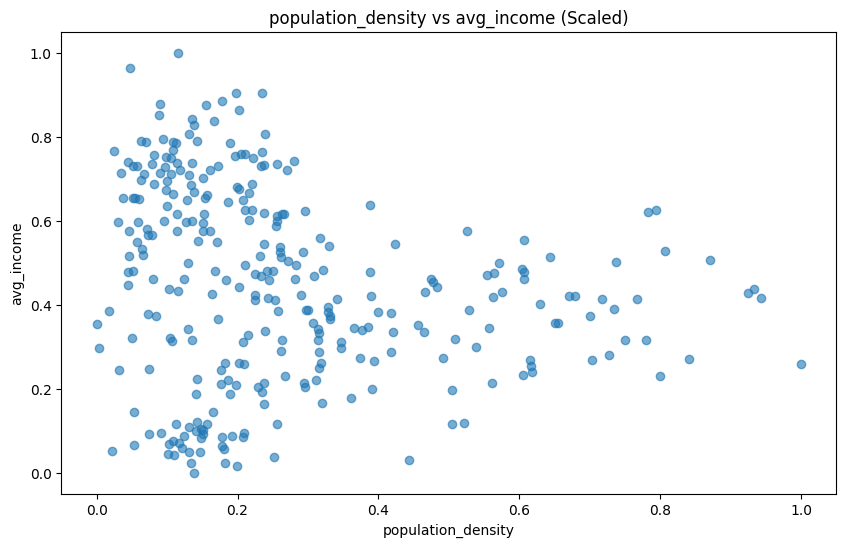

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], alpha=0.6)
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title(f'{df.columns[0]} vs {df.columns[1]} (Scaled)')
plt.show()

In [52]:
def calculate_distance(point, centroids):
    return np.sqrt(np.sum((point - centroids) ** 2, axis=1))

In [53]:
def k_means(df: pd.DataFrame, k: int, max_iters: int = 100):
    """
    K-means clustering algorithm.
    
    Args:
        df: DataFrame with numerical features (excluding any 'cluster' column)
        k: Number of clusters
        max_iters: Maximum number of iterations
    
    Returns:
        df: DataFrame with 'cluster' column added
        centroids: Final centroid positions
    """
    convergence_threshold = 1e-4
    last_move = np.inf
    iteration = 0
    
    # Create a copy to avoid modifying original data
    df = df.copy()
    
    # Initialize cluster column if it doesn't exist
    if 'cluster' not in df.columns:
        df['cluster'] = -1
    
    # Get feature columns (exclude cluster column)
    feature_cols: list[str] = [col for col in df.columns if col != 'cluster']
    X = df[feature_cols]
    
    # Initialize centroids randomly from the data points
    centroids: np.ndarray = X.sample(n=k, random_state=42).values
    
    while last_move > convergence_threshold and iteration < max_iters:
        # Store old centroids to calculate movement
        old_centroids = centroids.copy()
        
        # Step 1: Assign each data point to the nearest centroid
        # creates a matrix of shape (len(X), k) where each column j contains distances to centroid j
        distances = np.zeros((len(X), k))
        
        # distance calculation for all points and centroids
        for j in range(k):
            distances[:, j] = np.sqrt(np.sum((X - centroids[j]) ** 2, axis=1))
        
        # pick as a cluster the index of the closest centroid
        df['cluster'] = np.argmin(distances, axis=1)
        
        # Step 2: Update centroids as mean of assigned points
        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            cluster_points = X[df['cluster'] == j]
            if len(cluster_points) > 0:
                new_centroids[j] = cluster_points.mean(axis=0)
            else:
                # If cluster is empty, reinitialize randomly
                new_centroids[j] = X.sample(n=1, random_state=iteration).values
        
        centroids = new_centroids
        
        # Calculate centroid movement
        last_move = np.max(np.sqrt(np.sum((centroids - old_centroids) ** 2, axis=1)))
        print(f"Iteration {iteration}: max centroid move = {last_move:.6f}")
        
        iteration += 1
    
    return df, centroids

In [54]:
df_clustered, centroids = k_means(df_scaled, k=5)

# Convert normalized values back to original scale for visualization
df_clustered[df.columns] = scaler.inverse_transform(df_clustered[df.columns])
# Convert centroids back to original scale and plot them
centroids_original = scaler.inverse_transform(centroids)

df_clustered

Iteration 0: max centroid move = 0.166026
Iteration 1: max centroid move = 0.091560
Iteration 2: max centroid move = 0.077925
Iteration 3: max centroid move = 0.044188
Iteration 4: max centroid move = 0.019586
Iteration 5: max centroid move = 0.017104
Iteration 6: max centroid move = 0.010022
Iteration 7: max centroid move = 0.012435
Iteration 8: max centroid move = 0.002566
Iteration 9: max centroid move = 0.004414
Iteration 10: max centroid move = 0.000000


,population_density,avg_income,cluster
0,2775.0,3850.0,2
1,3861.0,3700.0,2
2,2562.0,4310.0,2
3,3192.0,3970.0,2
4,3496.0,4320.0,2
...,...,...,...
295,1004.0,4620.0,2
296,1652.0,4500.0,2
297,836.0,3910.0,2
298,758.0,3490.0,1


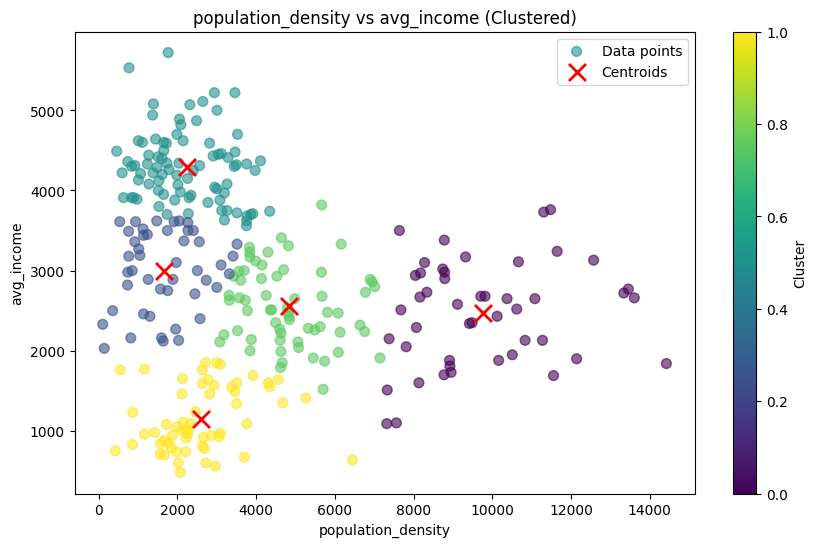

In [55]:
# visualize the clustered data
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(df_clustered.iloc[:, 0], df_clustered.iloc[:, 1], 
            c=df_clustered['cluster'], cmap='viridis', alpha=0.6, s=50, label='Data points')

plt.scatter(centroids_original[:, 0], centroids_original[:, 1], 
            c='red', marker='x', s=150, linewidths=2, label='Centroids', zorder=5)

plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title(f'{df.columns[0]} vs {df.columns[1]} (Clustered)')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()